# Introduction

**Objektif**<br>
* Membuat segmentasi customer berdasarkan fitur RFM

**Instruksi**<br>
* Proses data awal yang berupa transaksi menjadi data yang berisi informasi RFM setiap pelanggan
* Lakukan segmentasi pada data pelanggan yang dihasilkan
* Interpretasikan hasil segmentasi yang dilakukan!

$\textbf{Fardhani Rezky Pradipta}$ <br>
Email : fardhanirp@gmail.com<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
%matplotlib inline

# Load and Describe Data

## Load Data

In [2]:
data = pd.read_csv('Retail_Data_Transactions.csv')
response= pd.read_csv('Retail_Data_Response.csv')
data.sample(5)

,customer_id,trans_date,tran_amount
99894,CS1243,01-Jan-15,51
65508,CS3630,16-Jan-13,96
85240,CS4770,29-Oct-13,39
41005,CS3081,27-Jul-12,67
16385,CS2166,20-Jan-14,75


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


## Data Description

In [4]:
data.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


## Missing Value Check 

In [5]:
data.isnull().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

# Data Preparation

## Drop Duplicate Data

In [6]:
duplikat = data[data.duplicated(keep='last')]
print(duplikat)
data.shape

       customer_id trans_date  tran_amount
5116        CS3458  11-Feb-15           40
8479        CS2565  14-Sep-12           67
12521       CS2700  23-Oct-11           48
45968       CS2761  03-Mar-14           75
103710      CS7782  30-Dec-14           70
112719      CS8394  14-Jul-13           16


(125000, 3)

In [7]:
data = data.drop_duplicates()
data.shape

(124994, 3)

&nbsp;

# Feature Engineering

Recency merupakan informasi mengenai kapan terakhir kali customer melakukan transaksi. Untuk melihat recency, kita perlu melihat data riwayat transaksinya dengan melakukan perubahan tipe data fitur trans_date menjadi datetime64 sehingga mudah untuk melihat riwayat transaksi berdasarkan harinya.


## Add feature [trans_hist]

In [8]:
#ubah tipe data trans_date
data['trans_date']=pd.to_datetime(data['trans_date'])

#set data diambil sebulan kemudian
data['collect_date']=pd.to_datetime('2015-04-01') #diasumsikan data diambil di tanggal 1 april 2015

#menambah kolom trans_hist yang berisi riwayat terakhir transaksi
data['trans_hist']= data['collect_date']- data['trans_date']
data['trans_hist'] = round(data.trans_hist/np.timedelta64(1,'D'))

In [9]:
data.head()

,customer_id,trans_date,tran_amount,collect_date,trans_hist
0,CS5295,2013-02-11,35,2015-04-01,779.0
1,CS4768,2015-03-15,39,2015-04-01,17.0
2,CS2122,2013-02-26,52,2015-04-01,764.0
3,CS1217,2011-11-16,99,2015-04-01,1232.0
4,CS1850,2013-11-20,78,2015-04-01,497.0


## Create RFM table

In [10]:
#Membuat tabel RFM berdasarkan informasi dari data
rfm = data.groupby('customer_id').agg({'trans_hist': lambda x:x.min(), # Recency
                                        'customer_id': lambda x: len(x), # Frequency
                                        'tran_amount': lambda x: x.sum()}) # Monetary 

rfm.rename(columns={'customer_id':'customer_id',
                    'trans_hist': 'recency', 
                    'customer_id': 'frequency', 
                    'tran_amount': 'monetary'}, inplace=True)
rfm.shape


(6889, 3)

In [11]:
rfm.describe()

,recency,frequency,monetary
count,6889.000000,6889.000000,6889.000000
mean,96.538249,18.143998,1179.223835
std,85.382526,5.193150,465.833636
min,16.000000,4.000000,149.000000
25%,38.000000,14.000000,781.000000
50%,69.000000,18.000000,1227.000000
75%,127.000000,22.000000,1520.000000
max,873.000000,39.000000,2933.000000


In [12]:
rfm.isnull().sum()

recency      0
frequency    0
monetary     0
dtype: int64

In [13]:
#Merge tabel rfm dengan data response
#rfm = rfm.merge(response,on='customer_id')
rfm

,recency,frequency,monetary
customer_id,,,
CS1112,77.0,15,1012
CS1113,51.0,20,1490
CS1114,48.0,19,1432
CS1115,27.0,22,1659
CS1116,219.0,13,857
...,...,...,...
CS8996,113.0,13,582
CS8997,277.0,14,543
CS8998,100.0,13,624


## Data Distribution

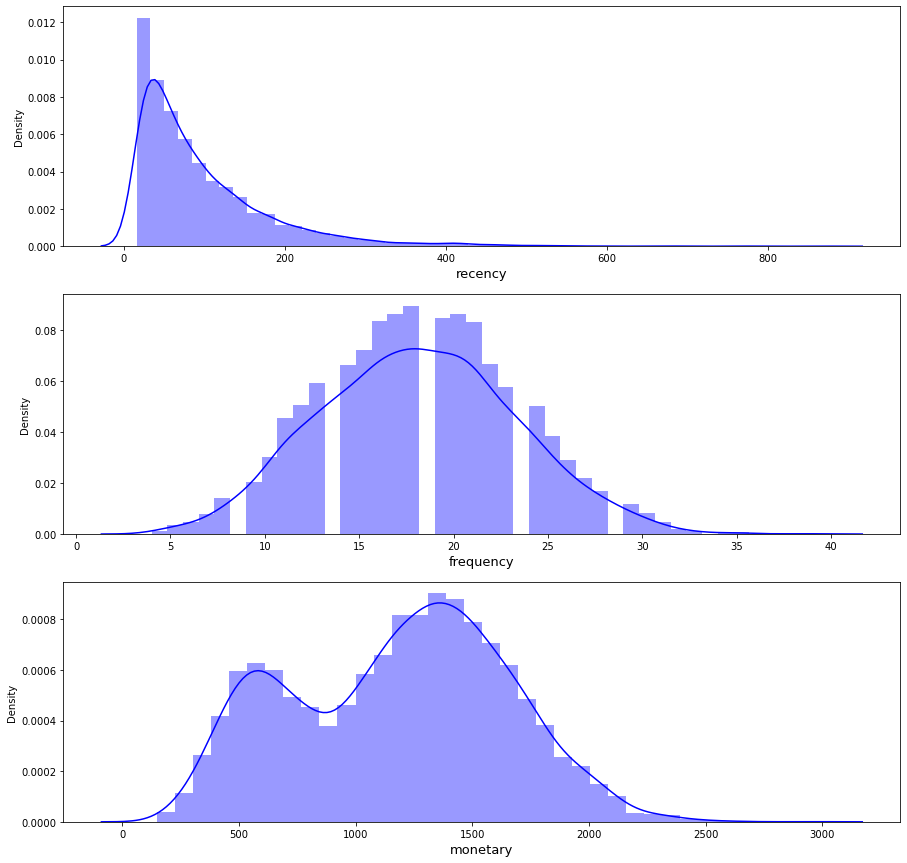

In [14]:
feature = ['recency','frequency','monetary']
plt.figure(figsize=(15,15))
for i in range(0, len(feature)):
    plt.subplot(3,1, i+1)
    sns.distplot(rfm[feature[i]],color = 'blue')
    plt.xlabel(feature[i],fontsize=13)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10);

In [15]:
rfm.skew(axis = 0, skipna = True) 

recency      2.314632
frequency    0.100124
monetary    -0.052605
dtype: float64

&nbsp;

# Data Preprocessing

## Log Transformation

Log transformation dilakukan untuk mengubah sebaran recency yang skew menjadi sebaran normal

In [16]:
rfm['recency'] =np.log1p(rfm['recency'])
#rfm['monetary']=np.log(rfm['monetary'])

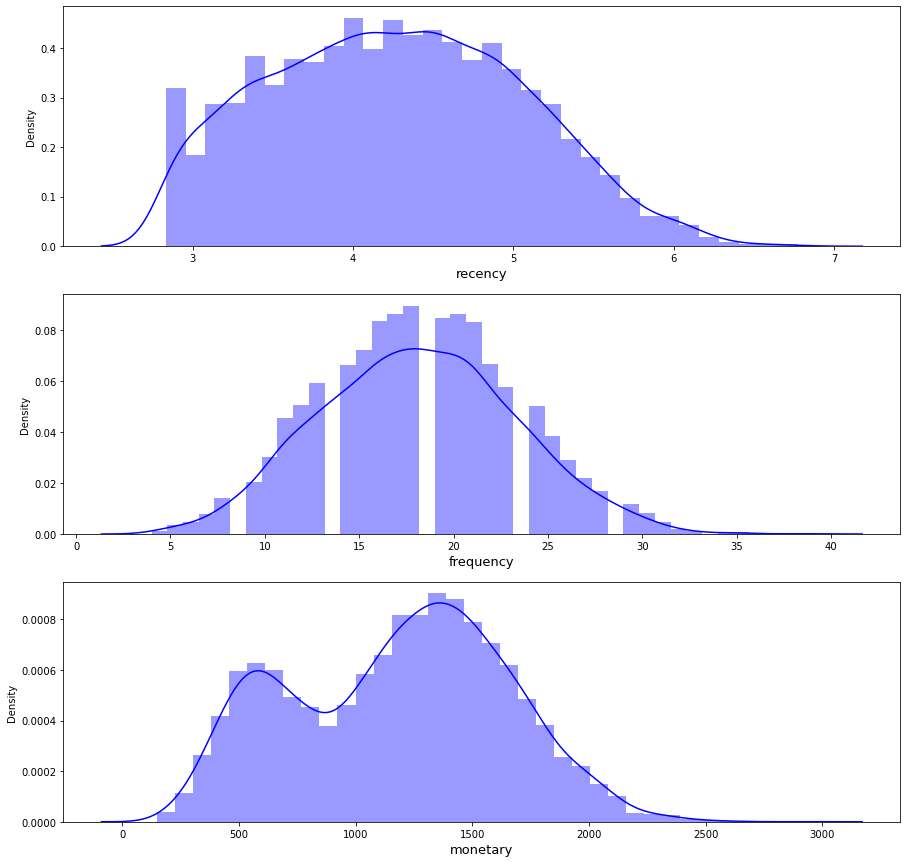

In [17]:
feature = ['recency','frequency','monetary']
plt.figure(figsize=(15,15))
for i in range(0, len(feature)):
    plt.subplot(3,1, i+1)
    sns.distplot(rfm[feature[i]],color = 'blue')
    plt.xlabel(feature[i],fontsize=13)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10);

In [18]:
rfm.skew(axis = 0, skipna = True)

recency      0.158263
frequency    0.100124
monetary    -0.052605
dtype: float64

## Data Standarization

In [19]:
feature = ['recency', 'frequency','monetary']
X = rfm[feature].values
#y = rfm['response'].values

from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
new_rfm = pd.DataFrame(data = X_std, columns = feature)
new_rfm.describe()

,recency,frequency,monetary
count,6.889000e+03,6.889000e+03,6.889000e+03
mean,8.126594e-16,2.564053e-15,-9.564131e-16
std,1.000073e+00,1.000073e+00,1.000073e+00
min,-1.828743e+00,-2.723785e+00,-2.211731e+00
25%,-7.715391e-01,-7.980317e-01,-8.549248e-01
50%,-2.679820e-02,-2.773040e-02,1.025680e-01
75%,7.416261e-01,7.425709e-01,7.315936e-01
max,3.187518e+00,4.016351e+00,3.765085e+00


&nbsp;

# Modelling

## K-Means clustering

### Inertia (menentukan nilai k)

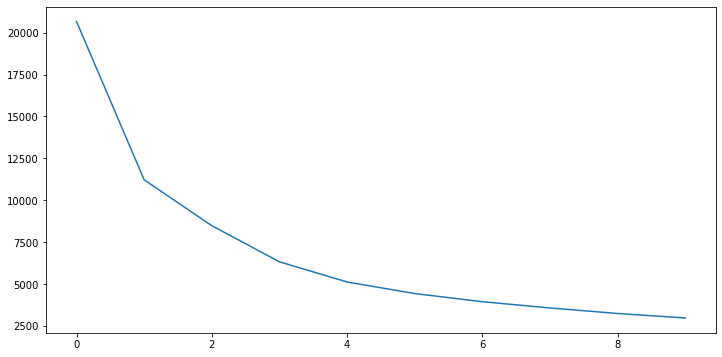

In [20]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
  kmeans.fit(new_rfm.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))
plt.plot(inertia)

### Data Fitting

In [21]:
from sklearn.cluster import KMeans
rfm_kmeans =  new_rfm.copy()
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(rfm_kmeans.values)

KMeans(n_clusters=4, random_state=0)

In [22]:
#rfm_kmeans['target'] = y
rfm_kmeans['fit'] = kmeans.labels_

### Model Visualization

<AxesSubplot:xlabel='recency', ylabel='frequency'>

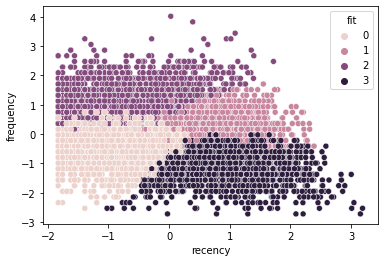

In [23]:
sns.scatterplot(data=rfm_kmeans, x='recency', y='frequency', 
                hue='fit')

In [24]:
#sns.scatterplot(data=rfm_kmeans, x='recency', y='frequency',hue='target')

<AxesSubplot:xlabel='frequency', ylabel='monetary'>

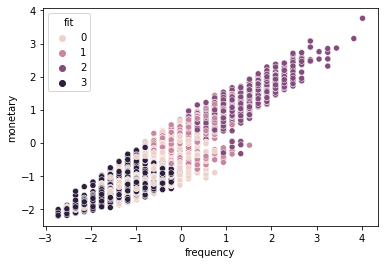

In [25]:
sns.scatterplot(data=rfm_kmeans, x='frequency', y='monetary', 
                hue='fit')

In [26]:
#sns.scatterplot(data=rfm_kmeans, x='frequency', y='monetary',hue='target')

<AxesSubplot:xlabel='recency', ylabel='monetary'>

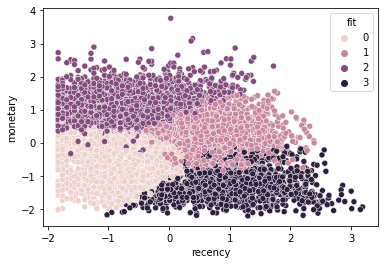

In [27]:
sns.scatterplot(data=rfm_kmeans, x='recency', y='monetary', 
                hue='fit')

In [28]:
#sns.scatterplot(data=rfm_kmeans, x='recency', y='monetary', hue='target')

In [29]:
rfm_kmeans.head()

,recency,frequency,monetary,fit
0,0.110980,-0.605456,-0.359004,0
1,-0.405261,0.357420,0.667188,2
2,-0.480919,0.164845,0.542671,2
3,-1.193425,0.742571,1.030005,2
4,1.431191,-0.990607,-0.691765,3


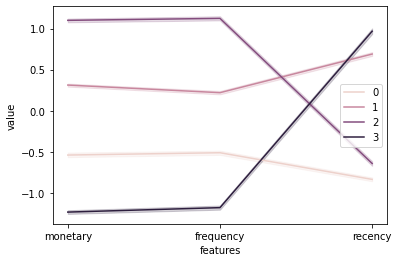

In [30]:
rfm_ = rfm_kmeans.copy()
rfm_['customer_id'] = rfm.index

melted_rfm = pd.melt(rfm_.reset_index(),
                     id_vars=['customer_id','fit'],
                     value_vars=['monetary','frequency','recency'],
                     var_name='features',
                     value_name='value')
sns.lineplot('features','value',hue='fit',data=melted_rfm)
plt.legend()

### Segmentasi Customer

Berdasarkan pemodelan menggunakan K-Means clustering, didapatkan 4 buah cluster:
- cluster 2 (best customer) : merupakan customer yang memiliki frekuensi dan nominal belanja yang besar serta masih aktif berbelanja belakangan ini, sangat potensial untuk diperkenalkan dengan produk baru
- cluster 0 (new customer) : meskipun frekuensi dan nominal belanjanya tidak besar namun masih aktif berbelanja belakangan ini, dapat diberikan pengalaman berbelanja yang baik agar meningkatkan customer engagement
- cluster 1 (at risk of churn customer) : merupakan customer yang memiliki frekuensi dan total belanja yang besar namun sudah agak lama terakhir berbelanja, bisa dilakukan analisa mengapa churn, dan diberikan promo supaya kembali berbelanja
- cluster 3 (infrequently customer) : merupakan customer yang memiliki frekuensi dan nominal belanja yang kecil serta sudah sangat lama terakhir berbelanja, ini merupakan customer yang sudah jelas churn sehingga harus meningkatkan kualitas dan layanan produk agar tidak ada lebih banyak lagi customer seperti ini

In [31]:
## Model Evaluation

In [32]:
#from sklearn import metrics
#true = np.array(rfm_kmeans.target)
#prediksi =  np.array(rfm_kmeans.fit)

#metrics.adjusted_rand_score(true,prediksi)

&nbsp;

## Agglomerative Clustering

### Data Fitting

In [33]:
from sklearn.cluster import AgglomerativeClustering
rfm_ac =  new_rfm.copy()
ac = AgglomerativeClustering(n_clusters=4)
ac.fit(rfm_ac.values)

AgglomerativeClustering(n_clusters=4)

In [34]:
#rfm_ac['target'] = y
rfm_ac['fit'] = ac.labels_

### Model Visualization

<AxesSubplot:xlabel='recency', ylabel='frequency'>

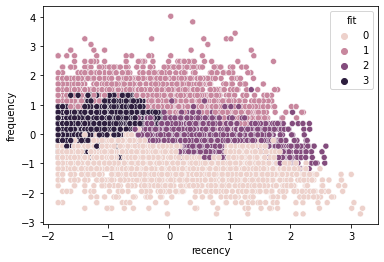

In [35]:
sns.scatterplot(data=rfm_ac, x='recency', y='frequency', 
                hue='fit')

In [36]:
#sns.scatterplot(data=rfm_ac, x='recency', y='frequency', hue='target')

<AxesSubplot:xlabel='frequency', ylabel='monetary'>

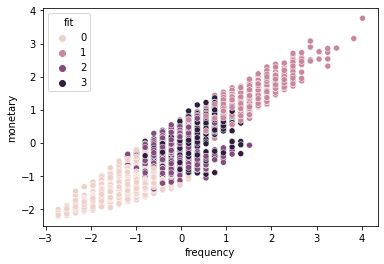

In [37]:
sns.scatterplot(data=rfm_ac, x='frequency', y='monetary', 
                hue='fit')

In [38]:
#sns.scatterplot(data=rfm_ac, x='frequency', y='monetary', hue='target')

In [39]:
rfm_ac.head()

,recency,frequency,monetary,fit
0,0.110980,-0.605456,-0.359004,2
1,-0.405261,0.357420,0.667188,3
2,-0.480919,0.164845,0.542671,3
3,-1.193425,0.742571,1.030005,3
4,1.431191,-0.990607,-0.691765,0


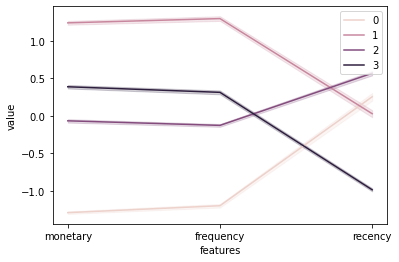

In [40]:
rfm_ = rfm_ac.copy()
rfm_['customer_id'] = rfm.index

melted_rfm = pd.melt(rfm_.reset_index(),
                     id_vars=['customer_id','fit'],
                     value_vars=['monetary','frequency','recency'],
                     var_name='features',
                     value_name='value')
sns.lineplot('features','value',hue='fit',data=melted_rfm)
plt.legend()

### Segmentasi Customer

Berdasarkan pemodelan menggunakan Agglomerative clustering, didapatkan 4 buah cluster:
- cluster 1 (best customer) : merupakan customer yang memiliki frekuensi dan nominal belanja yang besar serta masih aktif berbelanja belakangan ini, sangat potensial untuk diperkenalkan dengan produk baru
- cluster 3 (prospective customer) : memiliki frekuensi dan nominal belanjanya lumayan besar serta masih aktif berbelanja belakangan ini, dapat diberikan pengalaman berbelanja yang baik agar meningkatkan customer engagement
- cluster 2 (at risk of churn customer) : merupakan customer yang memiliki frekuensi dan total belanja yang besar namun sudah agak lama terakhir berbelanja, bisa dilakukan analisa mengapa churn, dan diberikan promo supaya kembali berbelanja
- cluster 0 (infrequently customer) : merupakan customer yang memiliki frekuensi dan nominal belanja yang kecil serta sudah sangat lama terakhir berbelanja, ini merupakan customer yang sudah jelas churn sehingga harus meningkatkan kualitas dan layanan produk agar tidak ada lebih banyak lagi customer seperti ini


In [41]:
## Model Evaluation

In [42]:
#from sklearn import metrics
#true = np.array(rfm_ac.target)
#prediksi =  np.array(rfm_ac.fit)

#metrics.adjusted_rand_score(true,prediksi)